In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import pandas as pd
import numpy as np

from matplotlib import cm
from matplotlib.cm import viridis, plasma

class Database:
    Database = None
    Cursor = None

    def Initialize():
        Database.Database = mysql.connector.connect(
            host="localhost",
            user="WSN",
            password="wsn123", 
            database='WSN3',
            auth_plugin='mysql_native_password'
        )
        
        Database.Cursor = Database.Database.cursor()

    def Execute(query):
            Database.Cursor.execute(query)
            myresult = Database.Cursor.fetchall()
            
            ret = []
            for res in myresult:
                ret.append(res)

            return ret
    
def ListOfTuplesToLists(input):
     return list(map(list, zip(*input)))

Database.Initialize()

In [16]:

def PlotWSN(simulation_id):
    pos_x, pos_y, parent, level, color = ListOfTuplesToLists(Database.Execute(f'''select SensorNode.PosX, SensorNode.PosY, SensorNode.Parent, SensorNode.Level_, SensorNode.Color from 
                       SensorNode where SensorNode.SimulationID = {simulation_id}'''))
    #SN_colors = [(0.0, 1.0, 0.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.5, 0.0, 0.5, 1.0), (0.0, 0.5, 0.5, 1.0)]
    #SN_colors = [(i / (max(color)), 1.0 - (i / (max(color))), i / (max(color)), 1) for i in range(max(color) + 1)]
    SN_colors = [plasma(float(i)/(max(color) + 1)) for i in range(max(color) + 1)]
    print(color)
    print(max(color))

    fig, ax = plt.subplots()

    ax.set_title(f'Sensor Node Locations')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(-150, 150)
    ax.set_ylim(-150, 150)
    for x in range(len(pos_x)):
        if parent[x] != -1:
            ax.plot([pos_x[parent[x]], pos_x[x]], [pos_y[parent[x]], pos_y[x]], c=(0.7411764706, 0.7411764706, 0.7411764706, 1.0), zorder=-1)
        else:
            ax.plot([0, pos_x[x]], [0, pos_y[x]], c=(0.7411764706, 0.7411764706, 0.7411764706, 1.0),zorder=-1)
    for x in range(len(pos_x)):
        ax.scatter(pos_x[x], pos_y[x], c=SN_colors[color[x]], zorder=1)
    ax.scatter([0], [0], c=(1.0, 0.0, 0.0, 1.0), zorder=1)

    for i in [50, 100, 150]:
        ax.add_artist(plt.Circle( (0.0, 0.0 ), i, fill = False ))

    #plt.legend(['Sensor Node Location'])
    plt.show()



def PlotCorrelationATD_MTBF():
    #x, y = ListOfTuplesToLists(Database.Execute(f'''select Simulation.FailureMean, Simulation.ActualTotalDuration from 
    #                   Simulation where Simulation.FailureDistributionType = 'Exponential' '''))
    
    #dicti = {'MTBF' : x, 'CWSNEfficiency' : y}
    #df = pd.DataFrame(dicti)
    #sns.regplot(x='MTBF', y='CWSNEfficiency', data=df)

    def plot3d(distributionType):
        x, y, z = ListOfTuplesToLists(Database.Execute(f'''select Simulation.FailureMean, Simulation.FailureStddev, Simulation.ActualTotalDuration from 
                       Simulation where Simulation.FailureDistributionType = '{distributionType}' order by Simulation.FailureMean, Simulation.FailureStddev'''))
        
        mean_count = ListOfTuplesToLists(Database.Execute(f'''select count(*) from 
                       Simulation where Simulation.FailureDistributionType = '{distributionType}' group by Simulation.FailureMean '''))[0][0]
        stddev_count = ListOfTuplesToLists(Database.Execute(f'''select count(*) from 
                       Simulation where Simulation.FailureDistributionType = '{distributionType}' group by Simulation.FailureStddev '''))[0][0]
        
        x = list(set(list(x)))
        y = list(set(list(y)))
        x.sort()
        y.sort()
        #print(x)
        #print(y)
        print(z)



        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        y,x=np.meshgrid(np.array(y),np.array(x))
        #x = np.array(x)
        #y = np.array(y)
        z=np.reshape(np.array(z),(-1,mean_count))

        #print('this is x\n')
        #print(x)
        #print('this is y\n')
        #print(y)
        #print('this is z\n')
        #print(z)

        ax.set_xlabel('FailureMean')
        ax.set_ylabel('FailureStddev')
        ax.set_zlabel('ActualTotalDuration')

        my_col = cm.jet(z/np.amax(z))
        surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm)
        ax.set_zlim(8000000, 10000000)
        #ax.zaxis.set_major_locator(LinearLocator(10))
        #ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        #ax.xaxis.set_major_formatter(FuncFormatter(format_log))
        #ax.yaxis.set_major_formatter(FuncFormatter(format_log))
        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.show()
        
    #for distributionType in ['Weibull', 'Gamma', 'Lognormal']:
    for distributionType in ['Weibull']:
        plot3d(distributionType)




def PlotDelay_Level():
    x, y = ListOfTuplesToLists(Database.Execute(f'''select SensorNode.Level_, sum(SensorNode.SentPacketTotalDelay) / sum(SensorNode.SentPacketCount) 
                                                from SensorNode where SensorNode.Level_ is not null and SensorNode.DeltaOpt < 1500 and SensorNode.DeltaOpt > 10 group by SensorNode.Level_'''))
    fig, ax = plt.subplots()

    ax.bar(x, y)
    
    ax.set_title(f'Average Packet Delay for Each Level')
    ax.set_xlabel('Level')
    ax.set_ylabel('Average Packet Delay')
    plt.show()

def PlotDeltaOpt_Level():
    x, y = ListOfTuplesToLists(Database.Execute(f'''select SensorNode.Level_, avg(SensorNode.DeltaOpt)
                                                from SensorNode where SensorNode.Level_ is not null and SensorNode.DeltaOpt < 1500 and SensorNode.DeltaOpt > 10 group by SensorNode.Level_'''))
    fig, ax = plt.subplots()

    ax.bar(x, y)
    
    ax.set_title(f'Average DeltaOpt for Each Level')
    ax.set_xlabel('Level')
    ax.set_ylabel('Average DeltaOpt')
    plt.show()

def PlotEnergy_Level():
    x, y = ListOfTuplesToLists(Database.Execute(f'''select SensorNode.Level_, avg(SensorNode.EnergyConsumed)
                                                from SensorNode where SensorNode.Level_ is not null and SensorNode.DeltaOpt < 1500 and SensorNode.DeltaOpt > 10 group by SensorNode.Level_'''))
    fig, ax = plt.subplots()

    ax.bar(x, y)
    
    ax.set_title(f'Average Energy Consumption for Each Level')
    ax.set_xlabel('Level')
    ax.set_ylabel('Average Energy Consumption')
    plt.show()

def PlotCorrelationEnergyConsumed_DeltaOpt():
    x, y = ListOfTuplesToLists(Database.Execute(f'''select SensorNode.DeltaOpt, SensorNode.EnergyConsumed from 
                       SensorNode where SensorNode.DeltaOpt < 1500 and SensorNode.DeltaOpt > 10'''))
    
    dicti = {'DeltaOpt' : x, 'EnergyConsumed' : y}
    df = pd.DataFrame(dicti)
    sns.regplot(x='DeltaOpt', y='EnergyConsumed', data=df)
    print(df.corr())


def PlotCorrelationCollectionTime_DeltaOpt():
    x, y = ListOfTuplesToLists(Database.Execute(f'''select SensorNode.DeltaOpt, SensorNode.CollectionTime from 
                       SensorNode where SensorNode.DeltaOpt < 1500 and SensorNode.DeltaOpt > 10'''))
    
    dicti = {'DeltaOpt' : x, 'CollectionTime' : y}
    df = pd.DataFrame(dicti)
    sns.regplot(x='DeltaOpt', y='CollectionTime', data=df)
    print(df.corr())


def PlotCorrelationCollectionTotalTime_CWSN():
    x, y = ListOfTuplesToLists(Database.Execute(f'''select Simulation.TotalDurationToBeTransferred / (Simulation.ActualTotalDuration * 100), Simulation.CWSNEfficiency from 
                       Simulation'''))
    
    dicti = {'TotalDurationToBeTransferred / ActualTotalDuration' : x, 'CWSNEfficiency' : y}
    df = pd.DataFrame(dicti)
    sns.regplot(x='TotalDurationToBeTransferred / ActualTotalDuration', y='CWSNEfficiency', data=df)
    print(df.corr())


def PlotDeltaOptDistribution():
    x = ListOfTuplesToLists(Database.Execute(f'''select SensorNode.DeltaOpt from 
                    SensorNode where SensorNode.DeltaOpt < 1500 and SensorNode.DeltaOpt > 10'''))[0]
    plt.hist(x, density=True, bins=30, cumulative=False)  # density=False would make counts
    plt.ylabel('Probability')
    plt.xlabel('DeltaOpt')
    plt.show()

    plt.hist(x, density=True, bins=30, cumulative=True)  # density=False would make counts
    plt.ylabel('Probability')
    plt.xlabel('DeltaOpt')
    plt.show()

[1, 2, 1, 4, 1, 3, 0, 3, 2, 1, 7, 4, 1, 7, 4, 3, 4, 5, 9, 8, 4, 0, 2, 0, 5, 8, 1, 2, 0, 2, 7, 5, 6, 6, 7, 3, 6, 8, 0, 5, 3, 4, 4, 4, 7, 0, 6, 2, 5, 0, 4, 2, 6, 6, 7, 5, 9, 1, 3, 2, 3, 0, 0, 1, 2, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 2, 0, 2, 0, 0, 1, 0, 2, 1, 2, 4, 1, 0, 3, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
9


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22148\487469285.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pos_x[x], pos_y[x], c=SN_colors[color[x]], zorder=1)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22148\487469285.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([0], [0], c=(1.0, 0.0, 0.0, 1.0), zorder=1)


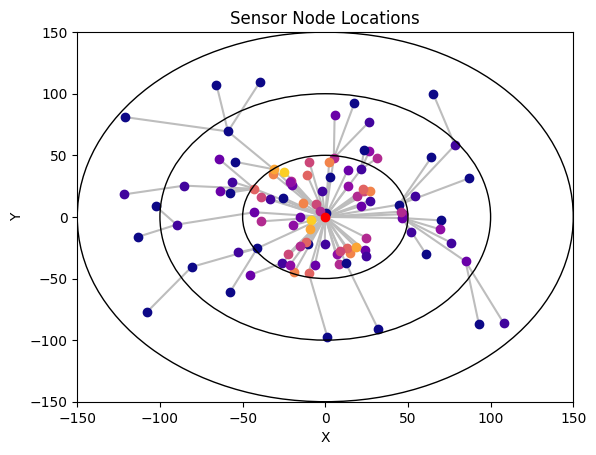

In [17]:
PlotWSN(1)

In [18]:
#PlotCorrelationCWSN_MTBF()

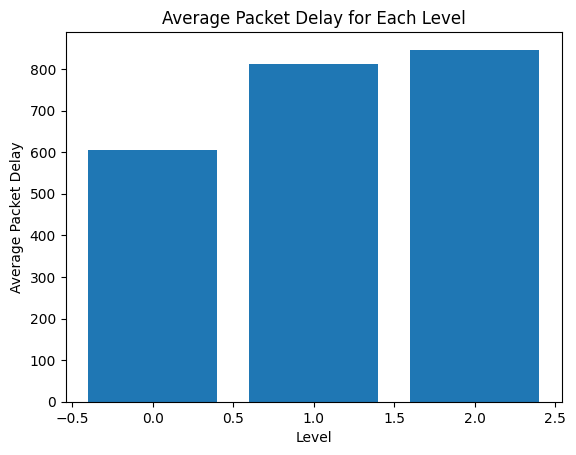

In [19]:
PlotDelay_Level()

                DeltaOpt  EnergyConsumed
DeltaOpt        1.000000       -0.261988
EnergyConsumed -0.261988        1.000000


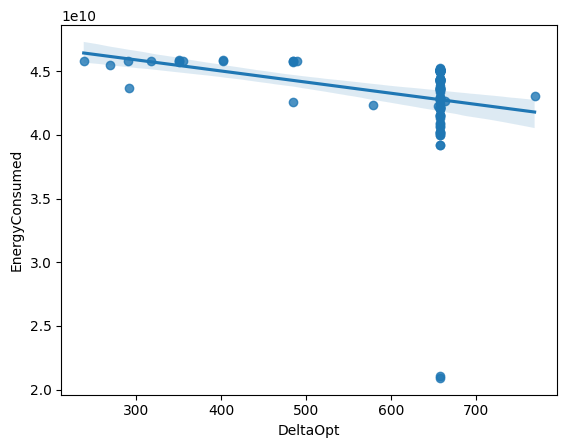

In [20]:
PlotCorrelationEnergyConsumed_DeltaOpt()

                DeltaOpt  CollectionTime
DeltaOpt        1.000000        0.225677
CollectionTime  0.225677        1.000000


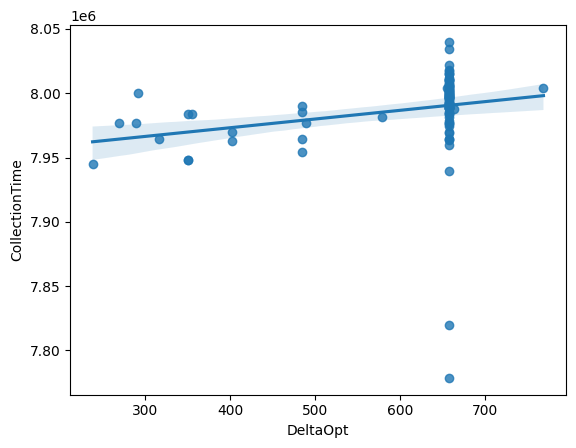

In [21]:
PlotCorrelationCollectionTime_DeltaOpt()

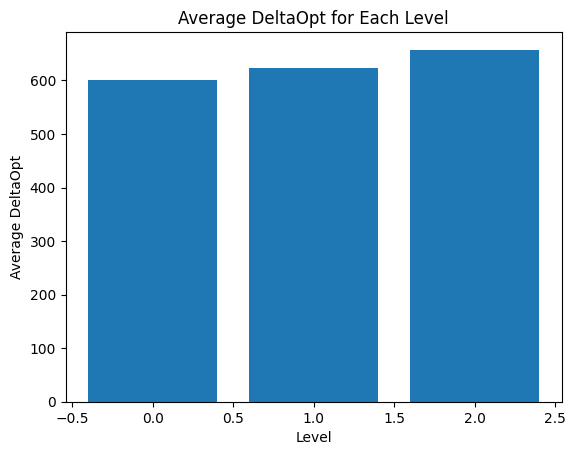

In [22]:
PlotDeltaOpt_Level()

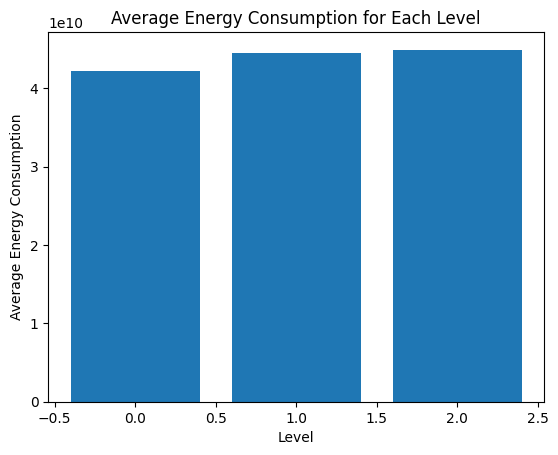

In [23]:
PlotEnergy_Level()

                                                    TotalDurationToBeTransferred / ActualTotalDuration  \
TotalDurationToBeTransferred / ActualTotalDuration                                                NaN    
CWSNEfficiency                                                                                    NaN    

                                                    CWSNEfficiency  
TotalDurationToBeTransferred / ActualTotalDuration             NaN  
CWSNEfficiency                                                 NaN  


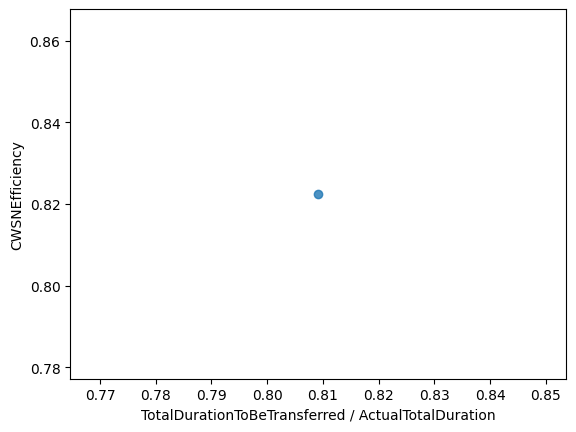

In [24]:
PlotCorrelationCollectionTotalTime_CWSN()

[9610140.0]


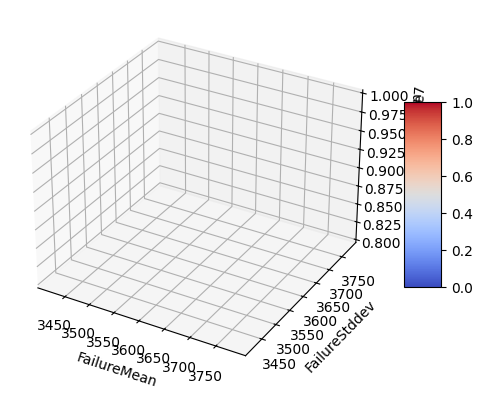

In [25]:
PlotCorrelationATD_MTBF()

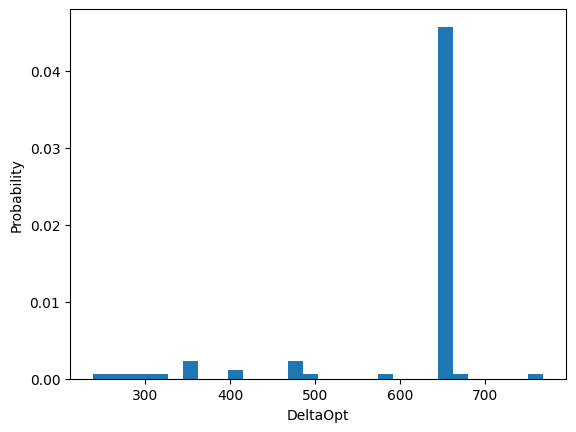

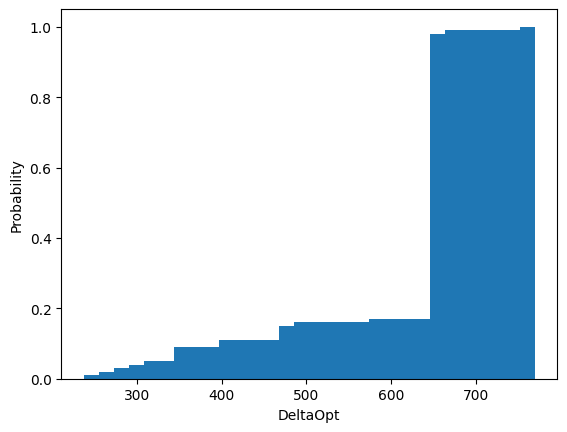

In [26]:
PlotDeltaOptDistribution()